In [100]:
# conda install -c numba numba
# conda install -c omnia parmed
# conda install -c conda-forge mdtraj
# conda install -c pytorch pytorch
# conda install -c conda-forge tqdm
import os
import sys
import numpy as np
import pandas as pd
import mdtraj as md
import parmed as pmd
import matplotlib.pyplot as plt
import numba  # njit, prange

sys.path.append(os.path.expanduser('~/masif_my/source'))

import mdtraj_utils as mdu
import mdtraj_utils.trajectory_utils as mdu_traj
import my_utils as my
import data_preparation.extract_and_triangulate_lib as ext_and_trg

# setup data connector
dc = mdu.data.DataConnector("database", safe=True)

## Input parameters

PDB Ids: 1AK4, 1CGI, 1E96, 1FLE, 1GPW, 1JTG, 1R0R, 1R6Q, 1RKE, 1Z0K, 1ZHH, 2HQS, 2I25, 2O3B, 2OOB, 3F1P

MD Ids:
* uR: unbound conformation of the receptor
* uL: unbound conformation of the ligand
* C: structure of the bound complex (R+L)
* bR: bound conformation of the receptor taken from the structure of the complex (C)
* bL: bound conformation of the ligand taken from the structure of the complex (C)
* sepB: seperatated (~10A) complex
* sepU: seperatated (~10A) complex but swaping the subunits with the unbound conformations

## Load data

In [101]:
pdb_id = '1Z0K'
md_runs = ['C', 'uR', 'uL', 'bR']

In [103]:
for md_id in md_runs:
    #dc.load_trajectory(pdb_id, md_id)
    dc.load_reference(pdb_id, md_id)
    dc.load_info(pdb_id, md_id)
    print(dc[pdb_id][md_id])

{'info': {'pdbid': '1Z0K', 'mdid': 'C', 'rid': '1', 'prmtop_filepath': 'raw_data/data/rep1/1Z0K/C/prmtop', 'inpcrd_filepath': 'raw_data/data/rep1/1Z0K/C/inpcrd', 'MODIFIED': '2020-07-08_09:58:36'}, 'traj_ref': <mdtraj.Trajectory with 1 frames, 3691 atoms, 232 residues, and unitcells at 0x7f6364204f28>}
{'traj_ref': <mdtraj.Trajectory with 1 frames, 2736 atoms, 171 residues, and unitcells at 0x7f63644bb0f0>, 'info': {'pdbid': '1Z0K', 'mdid': 'uR', 'rid': '1', 'prmtop_filepath': 'raw_data/data/rep1/1Z0K/uR/prmtop', 'inpcrd_filepath': 'raw_data/data/rep1/1Z0K/uR/inpcrd', 'MODIFIED': '2020-07-08_09:58:47'}}
{'traj_ref': <mdtraj.Trajectory with 1 frames, 955 atoms, 61 residues, and unitcells at 0x7f6364432470>, 'info': {'pdbid': '1Z0K', 'mdid': 'uL', 'rid': '1', 'prmtop_filepath': 'raw_data/data/rep1/1Z0K/uL/prmtop', 'inpcrd_filepath': 'raw_data/data/rep1/1Z0K/uL/inpcrd', 'MODIFIED': '2020-07-08_09:58:35'}}
{'traj_ref': <mdtraj.Trajectory with 1 frames, 2736 atoms, 171 residues, and unitcel

In [104]:
uL_trj = dc[pdb_id]['uL']['traj_ref']
uR_trj = dc[pdb_id]['uR']['traj_ref']
C_trj = dc[pdb_id]['C']['traj_ref']

In [105]:
frame_i = 13400
def save_named_pdb(dc, pdb_id, md_id, frame_i):
    dc[pdb_id][md_id]['traj'][frame_i].save(os.path.join('-'.join([pdb_id, md_id, str(frame_i)]) + '.pdb'))
    
for md_id in md_runs:
    save_named_pdb(dc, pdb_id, md_id, frame_i)


In [10]:
uR_traj = dc[pdb_id]['uR']['traj']
bR_traj = dc[pdb_id]['bR']['traj']
main_chain_atom_ids = mdu_traj.chain_atom_indices(uR_traj, 0)
rmsd_self = md.rmsd(uR_traj, uR_traj, frame=0, atom_indices=main_chain_atom_ids)
rmsd_ub = md.rmsd(uR_traj, bR_traj, frame=0, atom_indices=main_chain_atom_ids)

these frames were not found:

10 worst cases:
frame 24300 : ROCAUC =  0.6114996405463695
frame 1500 : ROCAUC =  0.619061095300157
frame 28450 : ROCAUC =  0.659316819185863
frame 20250 : ROCAUC =  0.6748578305041426
frame 17600 : ROCAUC =  0.6809941550225082
frame 15000 : ROCAUC =  0.6865985386331334
frame 31200 : ROCAUC =  0.6913640674394099
frame 2050 : ROCAUC =  0.6933823335803407
frame 16300 : ROCAUC =  0.6978614390513576
frame 1750 : ROCAUC =  0.6989044931902075


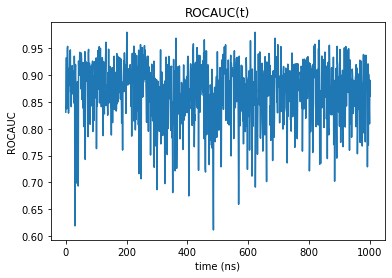

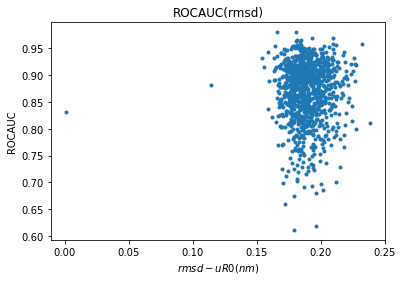

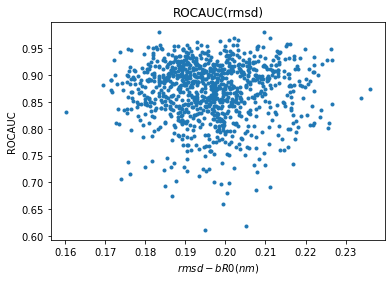

In [11]:
pdb_dir = 'PDBS'
step = 50

traj_id = '-'.join([pdb_id, 'uR'])

data = np.loadtxt(os.path.join(pdb_dir, traj_id + '.dat'))
frames_ids = np.intc(data[:, 0])
roc_auc = data[:, 1]
min_acc = np.argmin(roc_auc)
time = frames_ids * 0.02

uR_traj = dc[pdb_id]['uR']['traj']
N_frames = uR_traj.n_frames
rmsd_self_picked = rmsd_self[frames_ids]
rmsd_ub_picked = rmsd_ub[frames_ids]

print('these frames were not found:')
for f_i in range(0, N_frames, step):
    if(not f_i in frames_ids):
        print(f_i)
        
sorted_frames_ids = sorted(enumerate(frames_ids), key=lambda f_i: roc_auc[f_i[0]])
N_worst_cases = 10
print('\n' + str(N_worst_cases) + ' worst cases:')
for i in range(N_worst_cases):
    print('frame', sorted_frames_ids[i][1], ': ROCAUC = ', roc_auc[sorted_frames_ids[i][0]])

fig_time, ax_time = my.get_fig('time (ns)', 'ROCAUC', title='ROCAUC(t)')
ax_time.plot(time, roc_auc)

fig_rmsd_self, ax_rmsd_self = my.get_fig('$rmsd - uR0 (nm)$', 'ROCAUC', title='ROCAUC(rmsd)')
ax_rmsd_self.plot(rmsd_self_picked, roc_auc, '.')

fig_rmsd_ub, ax_rmsd_ub = my.get_fig('$rmsd - bR0 (nm)$', 'ROCAUC', title='ROCAUC(rmsd)')
ax_rmsd_ub.plot(rmsd_ub_picked, roc_auc, '.')

Text(0, 0.5, 'rmsd uR-bR (nm)')

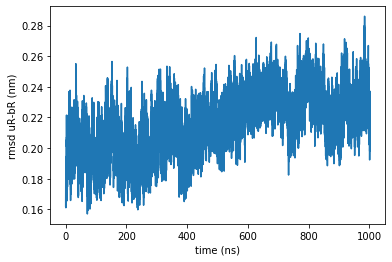

In [113]:
plt.plot(np.arange(N_frames) * 0.02, rmsd_uR_bR_superposed_chainA)
plt.xlabel('time (ns)')
plt.ylabel('rmsd uR-bR (nm)')

Text(0, 0.5, 'rmsd uR-uR0 (nm)')

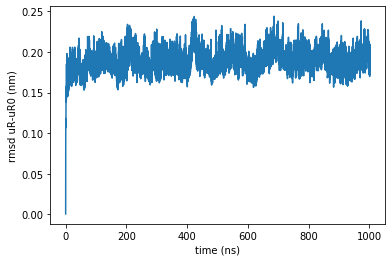

In [114]:
plt.plot(np.arange(N_frames) * 0.02, rmsd_uR_uR0_chainA)
plt.xlabel('time (ns)')
plt.ylabel('rmsd uR-uR0 (nm)')

Text(0, 0.5, 'rmsd bR-bR0 (nm)')

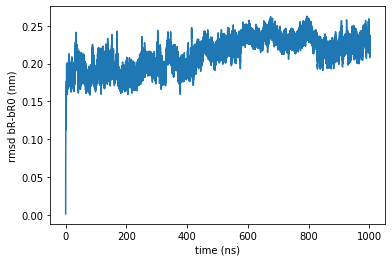

In [115]:
plt.plot(np.arange(N_frames) * 0.02, rmsd_bR_bR0_chainA)
plt.xlabel('time (ns)')
plt.ylabel('rmsd bR-bR0 (nm)')

/home/student/masif_my/source/my_utils.py:384: UserWarning: Log scale: values of z <= 0 have been masked
  CS = ax.contour(X, Y, Z, norm=LogNorm(vmin=10**min_scale, vmax=10**max_scale), levels=np.logspace(min_scale, max_scale, num=10))
/home/student/masif_my/source/my_utils.py:384: UserWarning: Log scale: values of z <= 0 have been masked
  CS = ax.contour(X, Y, Z, norm=LogNorm(vmin=10**min_scale, vmax=10**max_scale), levels=np.logspace(min_scale, max_scale, num=10))


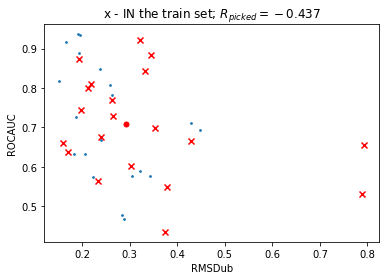

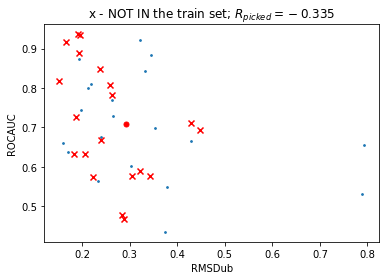

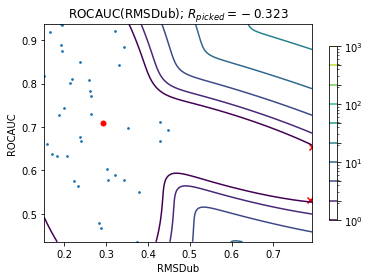

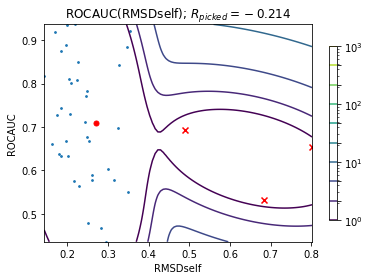

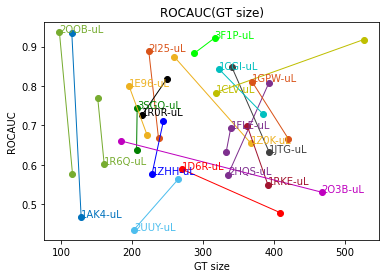

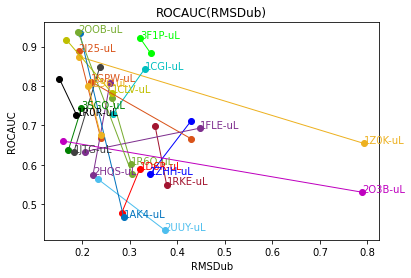

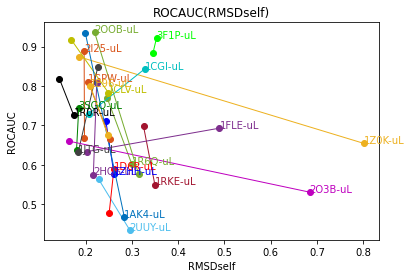

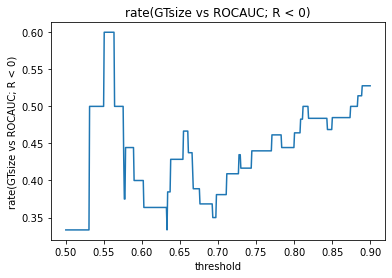

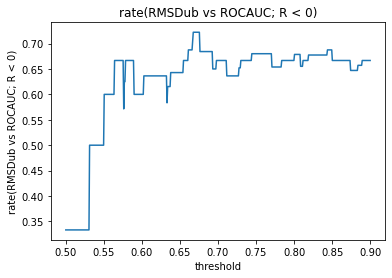

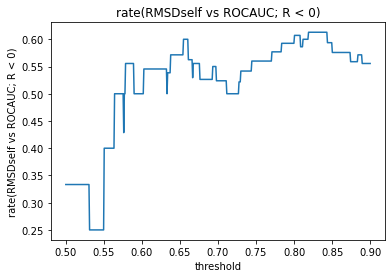

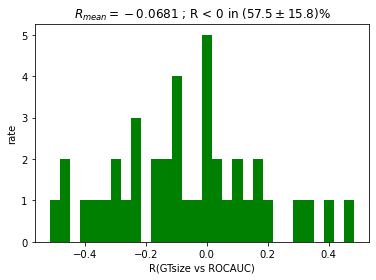

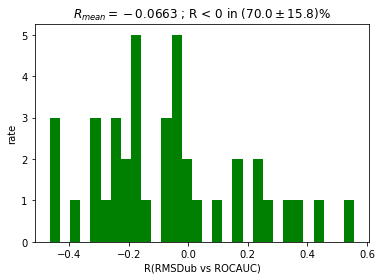

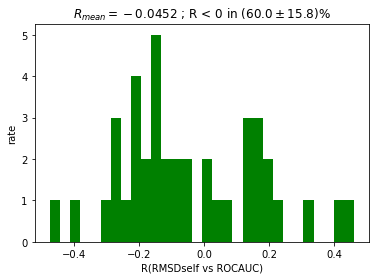

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

sys.path.append(os.path.expanduser('~/masif_my/source'))

import my_utils as my

def threshold_anal(rocauc, y, title, th_min=0.5, th_max=0.9, n_points=500):
    y_lbl = 'rate(' + title + '; R < 0)'
    fig, ax = my.get_fig('threshold', y_lbl, title=y_lbl)
    thresholds = np.linspace(th_min, th_max, n_points)
    rate = [np.mean(y[rocauc < t] < 0) for t in thresholds]
    ax.plot(thresholds, rate)

def just_hist(x, x_lbl, nbins=30):
    N_points = len(x)
    neg_rate = np.mean(x < 0)
    rate_err = 1 / np.sqrt(N_points)
    title = '$R_{mean} = ' + my.f2str(np.mean(x)) + '$ ; R < 0 in $(' + my.f2str(neg_rate * 100) + ' \pm ' + my.f2str(rate_err * 100) + ') \% $'
    fig, ax = my.get_fig('R(' + x_lbl + ')', 'rate', title=title)
    ax.hist(x, nbins, facecolor='g')

def just_scatter(x, y, x_lbl, y_lbl):
    fig, ax = my.get_fig(x_lbl, y_lbl)
    #ax.scatter(x, y)
    N = len(x) // 2
    for i in range(N):
        clr = my.colors[i % len(my.colors)]
        i1 = 2 * i
        i2 = i1 + 1
        ax.plot([x[i1], x[i2]], [y[i1], y[i2]], c=clr, linewidth=1, marker='o')
        ax.text(x[i2], y[i2], pdbs[i] + '-uL', c=clr)
    
def scatter_classif(x, y, x_lbl, y_lbl, n_comps=2, R_exclude_ids=[], title=None, draw_levels=True):  
    if(len(R_exclude_ids) == len(x)):
        include_ids = ~R_exclude_ids
    else:
        include_ids = []
        for i in range(len(x)):
            if(i not in R_exclude_ids):
                include_ids.append(i)
        include_ids = np.array(include_ids, dtype=np.intc)
        
    R = stats.pearsonr(x[include_ids], y[include_ids])[0]
    
    if(title is None):
        title = y_lbl + '(' + x_lbl + ')'
    title = title + '; $R_{picked} = ' + my.f2str(R) + '$'
        
    fig, ax = my.get_fig(x_lbl, y_lbl, title=title)
    my.gauss_classif(fig, ax, x, y, n_comps=n_comps, draw_levels=draw_levels)
    ax.scatter(x[R_exclude_ids], y[R_exclude_ids], marker='x', c='red')
    
def threshold_scatter(x, y, x_lbl, y_lbl, th):
    fig, ax = my.get_fig(x_lbl, y_lbl)
    under_th_ids = (y < th)
    ax.plot([min(x), max(x)], [th, th], '--', c='red')
    ax.scatter(x[~under_th_ids], y[~under_th_ids])    
    ax.scatter(x[under_th_ids], y[under_th_ids], marker='x', c='red')
    
pdbs = list(my.chain_ids_table.keys())
dat_filename = 'rocauc_done.dat'

data_lines = []
for l in open(dat_filename, 'r').readlines():
    if(l[0] != '#'):
        data_lines.append(l[:-1])
        
N_points = len(data_lines) 
ids = np.zeros(N_points)
ROCAUC_mean = np.zeros(N_points)
ROCAUC_t_k = np.zeros(N_points)
ROCAUC_t_k_err = np.zeros(N_points)
GTsize_mean = np.zeros(N_points)
GTsize_t_k = np.zeros(N_points)
GTsize_t_k_err = np.zeros(N_points)
GTsize_ROCAUC_R = np.zeros(N_points)
RMSDub_mean = np.zeros(N_points)
RMSDub_rocauc_R = np.zeros(N_points)
RMSDself_mean = np.zeros(N_points)
RMSDself_rocauc_R = np.zeros(N_points)

for i in range(len(data_lines)):
    data = data_lines[i].split()
    for j in range(len(data)):
        data[j] = float(data[j])            
     
    k = 0
    #ids[i] = data[k]; k += 1
    ROCAUC_mean[i] = data[k]; k += 1
    ROCAUC_t_k[i] = data[k]; k += 1
    ROCAUC_t_k_err[i] = data[k]; k += 1
    GTsize_mean[i] = data[k]; k += 1
    GTsize_t_k[i] = data[k]; k += 1
    GTsize_t_k_err[i] = data[k]; k += 1
    GTsize_mean[i] = data[k]; k += 1
    GTsize_ROCAUC_R[i] = data[k]; k += 1
    RMSDub_mean[i] = data[k]; k += 1
    RMSDub_rocauc_R[i] = data[k]; k += 1
    RMSDself_mean[i] = data[k]; k += 1
    RMSDself_rocauc_R[i] = data[k]; k += 1
    
with open('training.txt') as train_list_file:
    train_pdbs = train_list_file.readlines()
train_pdbs = [p[0:4] for p in train_pdbs]
in_training_set_ids = []
for p in pdbs:
    t = (p in train_pdbs)
    for i in range(2):
        in_training_set_ids.append(t)
in_training_set_ids = np.array(in_training_set_ids)

#print(np.argmin(RMSDub_rocauc_R))

#threshold_scatter(RMSDub_mean, ROCAUC_mean, 'RMSDub', 'ROCAUC', 0.6)
#threshold_scatter(RMSDub_mean, ROCAUC_mean, 'RMSDub', 'ROCAUC', 0.65)
#threshold_scatter(RMSDub_mean, ROCAUC_mean, 'RMSDub', 'ROCAUC', 0.7)

scatter_classif(RMSDub_mean, ROCAUC_mean, 'RMSDub', 'ROCAUC', n_comps=2, R_exclude_ids=in_training_set_ids, title='x - IN the train set', draw_levels=False)
scatter_classif(RMSDub_mean, ROCAUC_mean, 'RMSDub', 'ROCAUC', n_comps=2, R_exclude_ids=~in_training_set_ids, title='x - NOT IN the train set', draw_levels=False)

scatter_classif(RMSDub_mean, ROCAUC_mean, 'RMSDub', 'ROCAUC', n_comps=2, R_exclude_ids=[3, 21])
scatter_classif(RMSDself_mean, ROCAUC_mean, 'RMSDself', 'ROCAUC', n_comps=2, R_exclude_ids=[3, 21, 37])

just_scatter(GTsize_mean, ROCAUC_mean, 'GT size', 'ROCAUC')
just_scatter(RMSDub_mean, ROCAUC_mean, 'RMSDub', 'ROCAUC')
just_scatter(RMSDself_mean, ROCAUC_mean, 'RMSDself', 'ROCAUC')    

threshold_anal(ROCAUC_mean, GTsize_ROCAUC_R, 'GTsize vs ROCAUC')
threshold_anal(ROCAUC_mean, RMSDub_rocauc_R, 'RMSDub vs ROCAUC')
threshold_anal(ROCAUC_mean, RMSDself_rocauc_R, 'RMSDself vs ROCAUC')

just_hist(GTsize_ROCAUC_R, 'GTsize vs ROCAUC')
just_hist(RMSDub_rocauc_R, 'RMSDub vs ROCAUC')
just_hist(RMSDself_rocauc_R, 'RMSDself vs ROCAUC')